construir potencial con base empirica del snap63 en el halo del snap 40 y vicecersa
guardar potencial SL

* EBM 63 in POT 40
* EBM 40 in POT 53

In [2]:
import numpy as np
import scipy.stats as ss
from numpy import Inf
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import sys
import pyEXP
from schwimmbad import SerialPool,MultiPool
from scipy.stats import binned_statistic_2d, binned_statistic
from datetime import datetime
##  exp
#sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
#import simpleSL

## Auriga
import LibAu as la
import warnings
warnings.filterwarnings('ignore')
print(datetime.now())


2023-01-31 00:19:40.213135


In [2]:
nhalo = 16
Lsnap = np.arange(39,64,1,dtype=int)
colors = pl.cm.Blues(np.linspace(0,1,len(Lsnap)))[::-1]

plt.figure(figsize=(8,6))
RL,DL = [],[]
Datapos = {}
for ii,ns in enumerate(Lsnap):
    if ns not in (63,55): continue
    print('Au-%s snapshot %s'%(nhalo,ns))
    
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    #print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    try:
        fields_stars = ['pos','vel','id','mass','type','pot','age']
        Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)
    except KeyError:
        fields_stars = ['pos','vel','id','mass','type','pot']
        Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)

    fields_dm = ['pos','vel','id','mass','type','pot']
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
    
    #Rotate Halo---------------------------------------------------------------------
    Data = {'stars':Datstars,'dm1':DatDM}
    param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
    gal = la.ToolRot(Data=Data, param=param)
    Data = gal.Centered()#gal.Rotate()

    Datstars=Data['stars']
    DatDM = Data['dm1']
    #--------------------------------------------------------------------------------

    potdm = np.float64(DatDM['pot'])
    pos = np.float64(DatDM['pos']) #part_rot[not_in_subs]
    mass = np.float64(DatDM['mass'] )# #part['dark']['mass'][not_in_subs]

    poss,masss=Datstars['pos'],Datstars['mass']
    #print(type(mass[0]))
    
    rr = np.sqrt((pos[:,0]**2) + (pos[:,1]**2) + (pos[:,2]**2))
    
    binrad = 200
    
    rrmin,rrmax=np.nanmin(np.log10(rr)),np.nanmax(np.log10(rr))
    r,rho = return_density(np.log10(rr),weights= 1., rangevals=[rrmin, rrmax],bins=binrad)
    
    
    R,D,M,P = makemodel_empirical(r, rho, "Au{}_table.txt".format(nhalo))
    
    #plt.plot(R,np.log10(D),color=colors[ii],lw=1)#,zorder=ns)
    RL.append(R)
    DL.append(D)
    if ns in (63,55):Datapos['Snap'+str(ns)]=[pos,mass,potdm]

RL,DL = np.array(RL),np.array(DL)

Au-16 snapshot 55
! Scaling:  R= 554.4334746017048   M= 1.0
1.0 3.7480025733878034e-08 3.748002573387804e-08 3.7480025733878034e-08
Au-16 snapshot 63
! Scaling:  R= 575.9432091934026   M= 1.0
1.0 3.298520049294974e-08 3.298520049294975e-08 3.298520049294975e-08


<Figure size 576x432 with 0 Axes>

In [3]:
Rbin = np.linspace(np.nanmin(RL),np.nanmax(RL),50)
Rhomed = np.zeros_like(Rbin)
for i,rb in enumerate(Rbin):
    if rb==Rbin[-1]:continue
    sel = (Rbin[i]<=RL)&(RL<Rbin[i+1])
    Rhomed[i]= np.median(DL[sel])

In [4]:
R0,D0,M0,P0 = makemodel_empirical(RL[-1], DL[-1], "Au{}_Snap{}_table.txt".format(nhalo,63))
config="""
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 6
  nmax: 20
  modelname: %s_%s_table.txt
...
"""%(len(R0),round(np.nanmin(R0),3), round(np.nanmax(R0),3),'Au'+str(nhalo),'Snap'+str(63))
print(config)

! Scaling:  R= 575.9432091934026   M= 1.0
1.0 0.9999999999999992 0.9999999999999993 0.9999999999999993

---
id: sphereSL
parameters :
  numr: 200
  rmin: 0.017
  rmax: 575.943
  Lmax: 6
  nmax: 20
  modelname: Au16_Snap63_table.txt
...



R39,D39,M39,P39 = makemodel_empirical(RL[0], DL[0], "Au{}_Snap{}_table.txt".format(nhalo,39))
config39="""
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 6
  nmax: 20
  modelname: %s_%s_table.txt
...
"""%(len(R39),round(np.nanmin(R39),3), round(np.nanmax(R39),3),'Au'+str(nhalo),'Snap'+str(39))
print(config39)

In [5]:
# Construct the basis instances
#
basis = pyEXP.basis.Basis.factory(config)

# Prints info from Cache
#basis.cacheInfo('.slgrid_sph_cache')


lrmin = np.log10(np.nanmin(R))
lrmax = np.log10(np.nanmax(R))
rnum  = len(R) 
basis_grid = basis.getBasis(lrmin, lrmax, rnum)


r = np.linspace(lrmin, lrmax, rnum)
r = np.power(10.0, r)


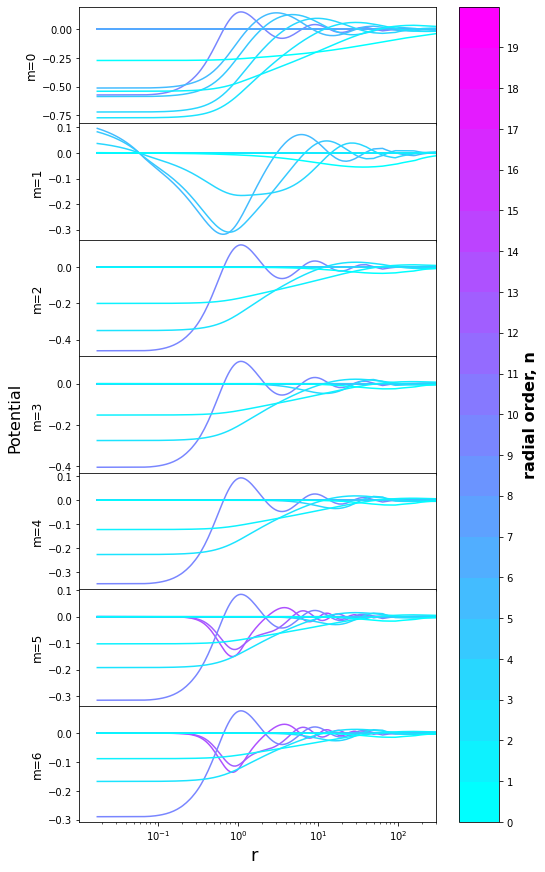

In [6]:
Nmax,lmax=20,6+1
colors =plt.get_cmap('cool', Nmax)
fig, ax = plt.subplots(nrows=lmax, ncols=1,figsize=(8,15))
plt.subplots_adjust(hspace=0)
for l in range(lmax):
    #plt.subplot(4,1,m+1)
    #ax=fig.add_subplot(4,1,m+1)
    for n in range(0,Nmax):
        ax[l].semilogx(r, basis_grid[l][n],c=colors(n),label='n = %s'%n,zorder=Nmax-n)
        ax[l].set_ylabel('m=%s'%l,fontsize=12)
        ax[l].set_xlim(0,300)
        if l!=lmax-1:ax[l].set_xticks([])

#plt.legend(title='radial order',fontsize=14,title_fontsize=18)

norm = mpl.colors.Normalize(vmin=0, vmax=Nmax)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])  
#cbar_ax = fig.add_axes([0.5, 0.15, 0.5, 0.7])

cb=plt.colorbar(sm,ax=ax.ravel().tolist(), ticks=np.arange(0, Nmax, 1))
cb.set_label(label='radial order, n', size=16, weight='bold')
plt.xlabel('r ',fontsize=18)

fig.text(0.00, 0.5, 'Potential', va='center', rotation='vertical',fontsize=16)

#plt.subplots_adjust(hspace=0.1)
plt.savefig('plots/PotEXPSL_Au%s_Snap%s.png'%(str(nhalo),63))
plt.show()
plt.close()

In [7]:
G_=4.300917270036279e-06

In [8]:
print(Datapos.keys())
len(Datapos['Snap55'])


dict_keys(['Snap55', 'Snap63'])


3

In [10]:

def GetFields(coords):
    dens0,potl0,dens,potl,fx,fy,fz = basis.getFields(x=coords[0],y=coords[1],z=coords[2])
    return dens0,dens,potl0,potl

pool = MultiPool()
Fields = np.array(list(pool.map(GetFields, np.array(Datapos['Snap55'][0]) )))
den0, den1,pot0,pot1 = np.array(Fields[:,0]),np.array(Fields[:,1]),np.array(Fields[:,2]),np.array(Fields[:,3])
pool.close()

In [11]:
Npx=50

pos,mass,potdm=Datapos['Snap55']
rr=np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
Hden,Hpot,Hpotmed,Hpotmed_ = np.zeros((Npx,Npx)),np.zeros((Npx,Npx)),np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
den_mon,den_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
pot_mon,pot_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
xb,yb=np.linspace(pos[:,0].min(), pos[:,0].max(),Npx),np.linspace(pos[:,1].min(), pos[:,1].max(),Npx)
dx,dy= xb[1]-xb[0],yb[1]-yb[0]
xgrid, ygrid = np.meshgrid(xb, yb)

rbord = np.argsort(rr)
rb,mb = rr[rbord],mass[rbord]
rbord1=np.argsort(rbord)
mbacc = np.cumsum(mb)
Pot_au=  ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb)))[rbord1]

def BS2D(dat):
    grid, _x, _y, _ = binned_statistic_2d(pos[:,0], pos[:,1], dat, 'median', bins=[Npx,Npx])
    return grid
dat = [potdm/G_,pot0,pot1]
pool = MultiPool()
DAT = list(pool.map(BS2D, dat ))
Hpotmed_,pot_mon,pot_nonmon = DAT
pool.close()
print(Hpotmed_.shape)


'''
for j in range(yb.size -1):
    for i in range(xb.size-1):
        la.PrintPercent((Npx*j)+i,Npx**2)
        sel = (xb[i]<=pos[:,0])&(pos[:,0]<=xb[i+1]) & (yb[j]<=pos[:,1])&(pos[:,1]<=yb[j+1])
        if len(pos[:,2][sel])>0:
            dz = np.nanmax(pos[:,2][sel])-np.nanmin(pos[:,2][sel])
            Hden[j][i] = np.sum(mass[sel])/(dx*dy*dz)
            den_mon[j][i],den_nonmon[j][i]=np.median(den0[sel]),np.median(den1[sel])
            
            Hpot[j][i] = np.sum(Pot_au[sel])/(dx*dy*dz)#potdm
            Hpotmed[j][i] = np.median(Pot_au[sel])#potdm
            Hpotmed_[j][i] = np.median(potdm[sel]/G_)#potdm
            pot_mon[j][i],pot_nonmon[j][i]=np.median(pot0[sel]),np.median(pot1[sel])
        else: pass'''


(50, 50)


'\nfor j in range(yb.size -1):\n    for i in range(xb.size-1):\n        la.PrintPercent((Npx*j)+i,Npx**2)\n        sel = (xb[i]<=pos[:,0])&(pos[:,0]<=xb[i+1]) & (yb[j]<=pos[:,1])&(pos[:,1]<=yb[j+1])\n        if len(pos[:,2][sel])>0:\n            dz = np.nanmax(pos[:,2][sel])-np.nanmin(pos[:,2][sel])\n            Hden[j][i] = np.sum(mass[sel])/(dx*dy*dz)\n            den_mon[j][i],den_nonmon[j][i]=np.median(den0[sel]),np.median(den1[sel])\n            \n            Hpot[j][i] = np.sum(Pot_au[sel])/(dx*dy*dz)#potdm\n            Hpotmed[j][i] = np.median(Pot_au[sel])#potdm\n            Hpotmed_[j][i] = np.median(potdm[sel]/G_)#potdm\n            pot_mon[j][i],pot_nonmon[j][i]=np.median(pot0[sel]),np.median(pot1[sel])\n        else: pass'

In [12]:
mask1,mask2,mask3 = np.isnan(pot_mon),np.isnan(pot_nonmon),np.isnan(Hpotmed_)
pot_mon[mask1],pot_nonmon[mask2],Hpotmed_[mask3]=0,0,0

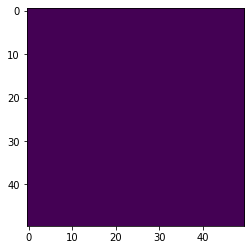

In [13]:
plt.imshow(pot_nonmon)

25616396011.046886


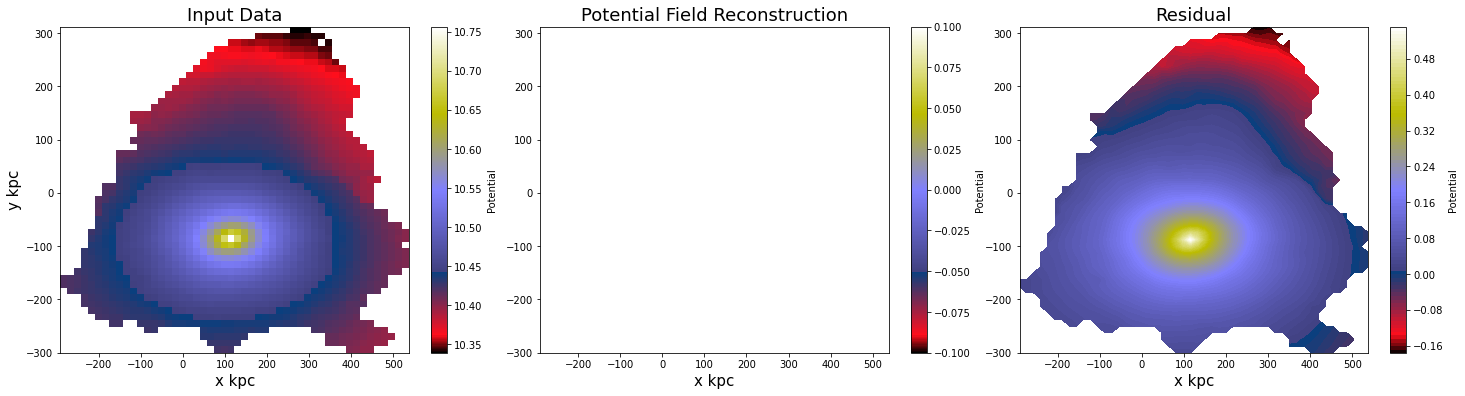

In [14]:
km2kpc=3.24078e-17
G= 6.674*1e-11 #m3⋅kg−1⋅s−2
m2kpc, kg2Msun = 3.2408*1e-20,5e-31
G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
mask=Hpotmed_/Hpotmed_
CC = np.median(np.abs(Hpotmed_- (pot_mon + pot_nonmon)))
print(CC)
Hpot_= np.log10(np.abs( Hpotmed_))#* (rb[-1]/(mbacc[-1]) )    ))
 

fig, ax = plt.subplots(1, 3, figsize=(25,6))
extent = xb.min(),xb.max(),yb.min(),yb.max()
im = ax[0].imshow(Hpot_,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
#im = ax[0].contourf(xgrid, ygrid, Hpot_,100,cmap='gist_stern')
plt.colorbar(im, ax=ax[0],label='Potential')


ax[0].set_title('Input Data',fontsize=18)
#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(pot_mon + pot_nonmon-(mask*CC))),100,cmap='gist_stern')
im2 = ax[1].imshow(np.log10(np.abs(pot_mon + pot_nonmon)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im2, ax=ax[1],label='Potential')
#im2.set_clim(im.get_clim()[0],im.get_clim()[1])
ax[1].set_title('Potential Field Reconstruction',fontsize=18)


potresidual = (Hpotmed_ - ((pot_mon + pot_nonmon)-(mask*CC)) )/(Hpotmed_)

#im3 = ax[2].imshow(denmask,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
im3 = ax[2].contourf(xgrid, ygrid, potresidual,100,cmap='gist_stern')
plt.colorbar(im3, ax=ax[2],label='Potential')
#im3.set_clim(7,12)
for i_ in [0,1,2]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    if i_==0:ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
ax[2].set_title('Residual',fontsize=18)
plt.savefig('plots/PotEXP_Au%s_Snap40_comparEBFsn63.png'%str(nhalo))
plt.show()

plt.close()

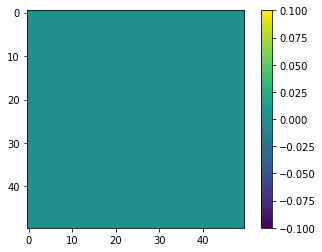

In [16]:
plt.imshow(pot_mon + pot_nonmon)
plt.colorbar() 

Text(0, 0.5, '$\\rho$')

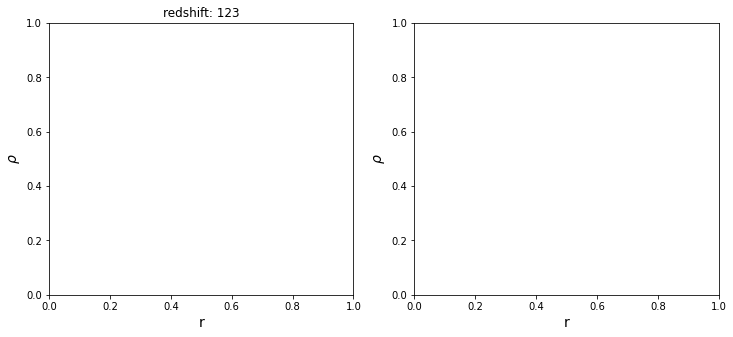

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.xlabel('r',fontsize=14)
plt.ylabel(r'$\rho$',fontsize=14)
plt.title('redshift: %s'%123)

plt.subplot(122)
plt.title('redshift: %s'%123)
plt.xlabel('r',fontsize=14)
plt.ylabel(r'$\rho$',fontsize=14)

plt.savefig('')
plt.close()

In [5]:
config= lambda numr,rmin,rmax,nh,nsnap: """
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 6
  nmax: 20
  modelname: %s_%s_table.txt
...
"""%(numr,rmin,rmax,nh,nsnap)

In [6]:
config(20,10,20,53)

TypeError: <lambda>() missing 1 required positional argument: 'nsnap'

In [ ]:
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 6
  nmax: 20
  modelname: %s_%s_table.txt
...
"""%(len(R0),round(np.nanmin(R0),3), round(np.nanmax(R0),3),'Au'+str(nhalo),'Snap'+str(63))